## Deriving the Allan deviation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.fftpack import fft, fftfreq
import numpy as np
import allantools
import os

figure_path = os.path.join(os.getcwd(), "report", "figures")
data_path = os.path.join(os.getcwd(), "laser_gyroscope_data", "allan")

In [2]:
# import data

# get only frequency and time 
data = np.genfromtxt(os.path.join(data_path, "defbuffer1_0405_161532_final.csv"), delimiter=",", skip_header=9, usecols=(0, 13))
# print(type(data[:,0]))

1.510262467866111


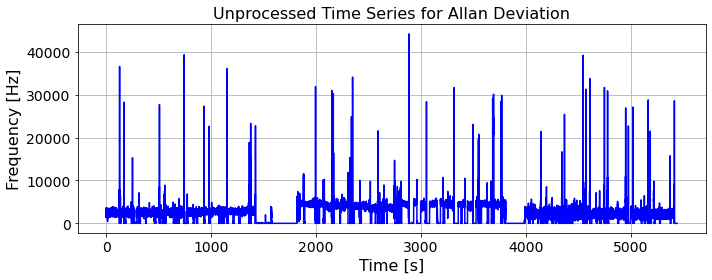

In [3]:
# plot the time series to check
freq = data[:,0]
time = data[:,1]
print(time[-1] / 3600)

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True)
ax.plot(time, freq, color="b")
ax.set_xlabel("Time [s]", fontsize=16)
ax.set_ylabel("Frequency [Hz]", fontsize=16)
ax.set_title("Unprocessed Time Series for Allan Deviation", fontsize=16)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.savefig(os.path.join(figure_path, "allan_ts_raw.png"), dpi=300)

Average frequency: 2430.7793322578013 Hz
Average frequency: 4221.7184533599475 Hz
Average frequency: 1967.522364255015 Hz


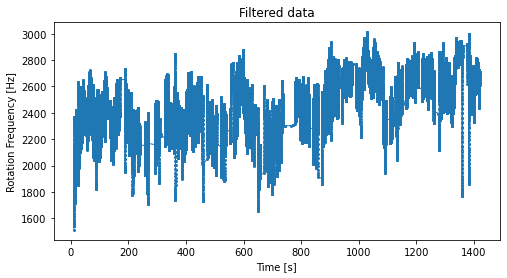

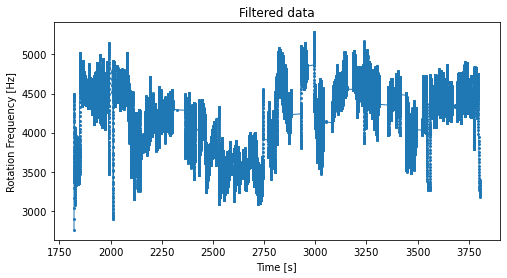

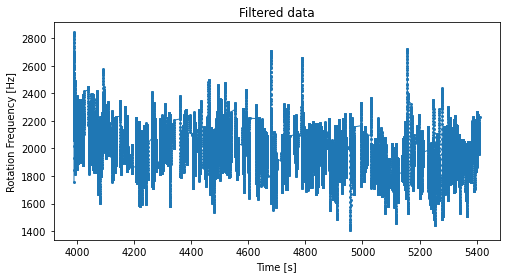

In [4]:
# remove places where the laser locked
# this is where the frequency reached zero or when it spiked, which is around freq > 4000 Hz
# or any perturbation around zero, so that we remove any frequency below 700 Hz

# from scipy.ndimage import uniform_filter1d
from scipy.signal import lfilter, ellip, sosfilt

# n = 15  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# yy = lfilter(b,a,y)

cut_vals = [(900, 3000), (2800,5600)]


# data_filt = data[(freq < 6000) & (freq > 900)]
# find indices where t ~ 1500 and t ~ 3800 
tbeg_idces = np.argwhere((time <=1500) & (time >=10))
tmid_idces = np.argwhere((time >=1800) & (time <=3850))
tend_idces = np.argwhere(time >=3950)

# print(tbeg_idces, tend_idces)

time_beg = time[tbeg_idces]
time_mid = time[tmid_idces]
time_end = time[tend_idces]
tme_list = [time_beg, time_mid, time_end]

freq_beg = freq[tbeg_idces]
freq_mid = freq[tmid_idces]
freq_end = freq[tend_idces]

sos = ellip(20, 0.009, 80, 0.05, output='sos')
# freq_filt = sosfilt(sos, data_filt[:,0])

freq_filts = []
time_filts = []


for i, frqs in enumerate([freq_beg, freq_mid, freq_end]):
    
    freq_cut = frqs[(frqs < cut_vals[i%2][1]) & (frqs > cut_vals[i%2][0])]
    time_cut = tme_list[i][(frqs < cut_vals[i%2][1]) & (frqs > cut_vals[i%2][0])]

    # freq_cut = data_cut[:,0]
    # time_cut = data_cut[:,1]

    freq_filt = sosfilt(sos, freq_cut)
    freq_filts.append(freq_filt[50:])
    time_filts.append(time_cut[50:])
# n = 15
# b = (1.0 / n) * n * np.ones_like(data_filt[:,0])
# a = np.ones_like(data_filt[:,0])
# freq_filt = lfilter(b,a,data_filt[:,0])



# freq_filt = uniform_filter1d(data_filt[:,0], size=5)
# t_filt = data_filt[:,1]

for i in range(3):
    plt.figure(figsize=(8,4))
    plt.plot(time_filts[i], freq_filts[i], marker="o",ls="-", ms=2.0, lw=1.0)
    plt.xlabel("Time [s]")
    plt.ylabel("Rotation Frequency [Hz]")
    plt.title("Filtered data")

    # print average frequency
    print("Average frequency: {0} Hz".format(np.mean(freq_filts[i])))


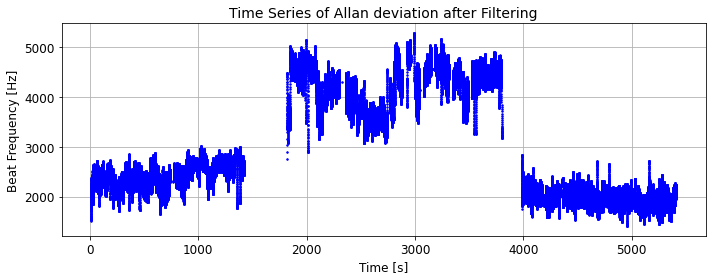

In [5]:
dt = time[1] - time[0]
# time_filted = np.hstack((time_filts[0], time_filts[2]))
# freq_filted = np.hstack((freq_filts[0], freq_filts[2]))
time_filted = np.hstack(tuple(time_filts))
freq_filted = np.hstack(tuple(freq_filts))


time_filted_v1 = np.linspace(0., dt * len(time_filted), len(time_filted))

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True)
ax.plot(time_filted, freq_filted, marker="o", ms=1.5, ls="", color="b")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Beat Frequency [Hz]", fontsize=12)
ax.set_title("Time Series of Allan deviation after Filtering", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.grid()

plt.savefig(os.path.join(figure_path, "allan_ts_filt.png"), dpi=300)

In [6]:
# sampling rate
dt = (time[-1] - time[0]) / len(time)
# dfreq = 1 / dt
# print("sample rate: {0} Hz".format(dfreq))
print(dt, 1 / dt)

0.019713003333217308 50.727937448017094


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sample rate: 50.727937448017094 Hz


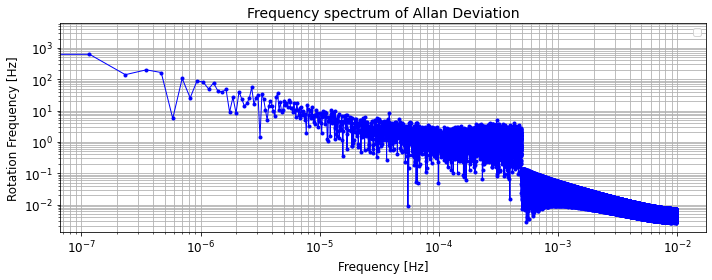

In [7]:
# perform fft on the filtered data
# determine allan deviation
# combine the frequency measurement after filtering
from scipy.fft import fft, fftfreq

# sampling rate
dt = (time[-1] - time[0]) / len(time)
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))


N = len(freq_filted)

y_fft = np.abs(fft(freq_filted, norm="forward"))[:N//2]
freq_fft = fftfreq(N, dfreq)[:N//2]

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True)
ax.loglog(freq_fft, y_fft, marker="o", ls="-", lw=1.0, ms=3.0, color="b")

ax.set_xlabel("Frequency [Hz]", fontsize=12)
ax.set_ylabel("Rotation Frequency [Hz]", fontsize=12)
ax.set_title("Frequency spectrum of Allan Deviation", fontsize=14)
ax.legend()
ax.grid(which="both")

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.savefig(os.path.join(figure_path, "allan_fs.png"), dpi=300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


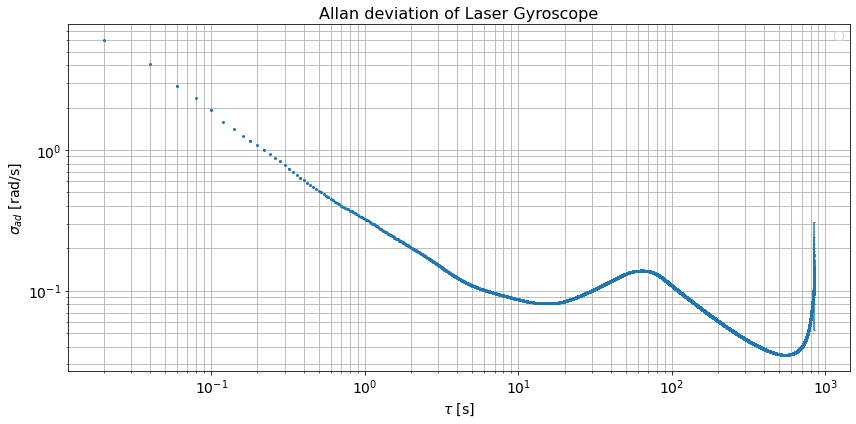

In [46]:


# get allan deviation
(t2, ad, ade, adn) = allantools.oadev(y_fft, rate=50, data_type="freq", taus=time_filted_v1)

fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
ax.errorbar(t2, ad, yerr=ade, marker="o", ls="", ms=2.0, capsize=1.0)   # the data
# ax.plot(t2, ad_thr, color="r", zorder=3, label = r'Fit, $\mathcal{{A}} = {0:.3f} \pm {1:.3f}$'.format(np.exp(logA), A_err))
# ax.plot(t2, ad_thr, color="r", zorder=3, label = r"Fit: $ {2:.8f} \tau + \log({0:.3f})$".format(np.exp(logA), A_err, slope, slope_err))

ax.set_xlabel(r"$\tau$ [s]", fontsize=14)
ax.set_ylabel(r"$\sigma_{{ad}}$ [rad/s]", fontsize=14)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=16)

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(prop={"size":14}, borderpad=0.3)
ax.grid(which='both')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# plt.savefig(os.path.join(figure_path, "allan.png"), dpi=300)

# # shot-noise
# tau_shotnoise = cutoff
# print("Shot-noise limitation: {0} s".format(tau_shotnoise))



In [51]:
cutoff = 10

# ad_cutoff = ad[(t2 > 4e-1) & (t2 < 1.2)]
# t2_cutoff = t2[(t2 > 4e-1) & (t2 < 1.2)]
ad_cutoff = ad[t2 < cutoff]
t2_cutoff = t2[t2 < cutoff]
ade_cutoff = ade[t2 < cutoff]

# aderr_cutoff = ade[(t2 > 4e-1) & (t2 < 1.5)] / np.sqrt(adn)

# take log on both sidfes
log_allandev = np.log(ad_cutoff)
log_tau = np.log(t2_cutoff)

# perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
(slope, logA), cov = np.polyfit(log_tau, log_allandev, 1, w=1/ade_cutoff, cov=True)

# variance is the diagonal elements of the covariance matrix
slope_err = cov[0,0]
logA_err = cov[1,1]
A_err = np.exp(logA) * logA_err

print("slope (should be ~ -1/2): {0:.8f} +- {3:.8f}, intercept: {1:.8f} +- {4:.8f}, A: {2:.3f} +- {5:.3f}".format(slope, logA, np.exp(logA), slope_err, logA_err, A_err))
ad_thr = np.exp(logA) * t2**slope

slope (should be ~ -1/2): -0.51583975 +- 0.00002514, intercept: -1.32157661 +- 0.00008762, A: 0.267 +- 0.000


Shot-noise limitation: 10 s


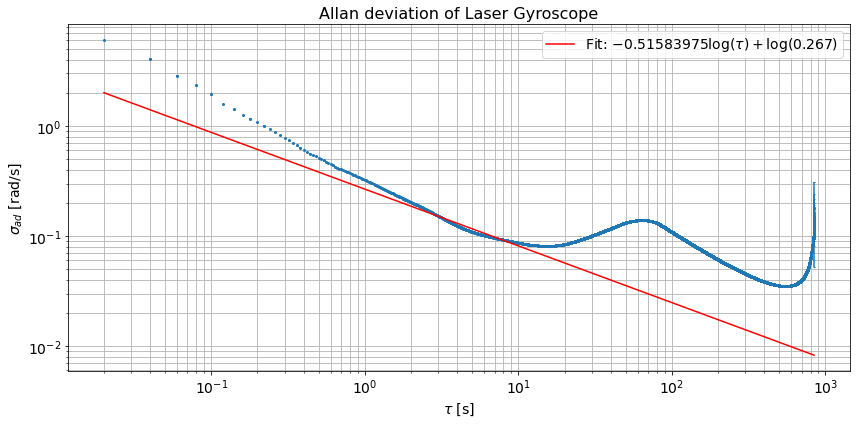

In [52]:
fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
ax.errorbar(t2, ad, yerr=ade, marker="o", ls="", ms=2.0, capsize=1.0)   # the data
# ax.plot(t2, ad_thr, color="r", zorder=3, label = r'Fit, $\mathcal{{A}} = {0:.3f} \pm {1:.3f}$'.format(np.exp(logA), A_err))
ax.plot(t2, ad_thr, color="r", zorder=3, label = r"Fit: $ {2:.8f} \log( \tau) + \log({0:.3f})$".format(np.exp(logA), A_err, slope, slope_err))

ax.set_xlabel(r"$\tau$ [s]", fontsize=14)
ax.set_ylabel(r"$\sigma_{{ad}}$ [rad/s]", fontsize=14)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=16)

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(prop={"size":14}, borderpad=0.3)
ax.grid(which='both')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.savefig(os.path.join(figure_path, "allan.png"), dpi=300)

# shot-noise
tau_shotnoise = cutoff
print("Shot-noise limitation: {0} s".format(tau_shotnoise))

In [53]:
# compare with theoretic values
F = 5592.366074495255  # the finesse of the ring, determined from ring-down
F_err = 0.35994123783513843

c = 3e8  # m/s
wvlgth = 1064e-9   # laser wavelength
Popt = 1e-6  # optical power in W = J/s
h =  6.62607015e-34   # in J*s

# obtained from cavity resonance analysis
P = 0.9976042591075841
P_err = 0.00027731796014057746 

# P = 4L
L = 0.25 * P
L_err = 0.25 * P_err

# A = L^2
area = L**2.
area_err = 2 * L * L_err

print("Area: {0} +- {1} m^2".format(area, area_err))

# analytical gyroscope sensitivity
delta_Omega = 0.25 * np.sqrt(c**3. * h * wvlgth / (Popt * tau_shotnoise)) / (area * F)
delta_Omega_err = delta_Omega * np.sqrt( (area_err / area)**2. + (F_err / F)**2.)

print("Theoretical gyroscope sensitivity: {0} +- {1} micro rad /s".format(delta_Omega, delta_Omega_err))


Area: 0.06220089111184949 +- 3.458169727040842e-05 m^2
Theoretical gyroscope sensitivity: 3.135656783069983e-08 +- 1.754967656404151e-11 micro rad /s


In [54]:
# determine the gyroscope sensitivity 
scale_factor = 5.91312352e6
scale_factor_err = 1.09789595e3

allan_dev_sn = np.exp(logA) / np.sqrt(4)
print(allan_dev_sn)
delta_Omega_ad = allan_dev_sn / scale_factor
print(delta_Omega_ad)

0.13335723244288733
2.2552756084298292e-08


In [55]:
print(np.exp(logA)  / np.sqrt(tau_shotnoise))

25581.53216565168


In [9]:
# determine the rotation table frequency by averageing
from scipy.io import loadmat
from scipy.signal import sosfilt, ellip
freq_path = os.path.join(data_path, "0.75v_freq_final")

tstart = 0.

# combine all frequencies into one
# also remove all points where we stopped the measurement
freq_list = []
time_list = []

for mat_file in os.listdir(freq_path):
    data = loadmat(os.path.join(freq_path, mat_file))
    # print(data)

    tint = float(data["Tinterval"])
    N = int(data["Length"])
    # print("Time interval: {0}, Length of array: {1}".format(tint, N))

    freq_data = np.array(data["freq_C_"])[:,0]

    # find where:
    # no nans, no zeros, no large values
    freq_goodval_idces = np.argwhere((~np.isnan(freq_data)) & (freq_data > 1) & (freq_data < 7.5))
    # print(freq_goodval_idces)
    freq = freq_data[freq_goodval_idces]

    t = np.linspace(tstart, tstart + tint * N, N)[freq_goodval_idces]

    # # print(freq_nans)
    # freq_withzeros = freq_nans[~np.isnan(freq_nans)]

    # # further remove where freq is zero
    # freq = freq_withzeros[np.nonzero(freq_withzeros)]

    # also remove any values that are larger than zero
    # print(len(freq))

    # do the same with time
    # t = np.linspace(tstart, tstart + tint * N, N)[~np.isnan(freq_nans)][np.nonzero(freq_withzeros)]

    # check
    # t = np.linspace(tstart, tstart + tint * N, N)[~np.isnan(freq_nans)][np.nonzero(freq_withzeros)]
    # plt.plot(t, freq)
    # print(freq)

    # append to list
    freq_list.append(freq)
    time_list.append(t)

    # update tstart with tint * N 
    # since tstart is the same for each file, zero
    tstart += tint * N


# concatenate them
freq_concat = np.concatenate(tuple(freq_list))[:,0]
time_concat = np.concatenate(tuple(time_list))[:,0]




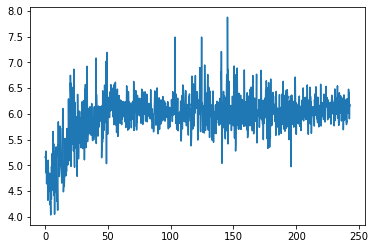

In [10]:
# finally apply filtering
sos = ellip(20, 0.009, 80, 0.05, output='sos')
freq_arr = sosfilt(sos, freq_concat)

plt.plot(time_concat[5000:], freq_arr[5000:])

In [12]:
# average frequency and standard error
Ntot = len(freq_arr)

rot_freq = np.mean(freq_arr) / 10000
# systematic error ==  width of signal, ~ 0.75 Hz
# combine both sys and stat error
freq_err = np.sqrt((np.std(freq_arr) / np.sqrt(Ntot))**2. + 0.75**2.) / 10000

print("Rotation frequency is: {0} +- {1} mHz".format(rot_freq * 1e3, freq_err * 1e3))

Rotation frequency is: 0.5959135190188412 +- 0.07500000022502526 mHz


In [9]:

# # determine allan deviation

# # sampling rate
# dt = time[1] - time[0]
# dfreq = 1 / dt
# print("sample rate: {0} Hz".format(dfreq))

# # cutoff_ranges = [(3e-1, 1.5e0), (3e-1, 1.5e0), (3e-1, 1e1)]
# cutoffs = [1e1, 1.5e1, 1e1]

# for i in range(3):
#     # get allan deviation
#     y_fft = np.abs(fft(freq_filts[i]))[:N//2]
#     (t2, ad, ade, adn) = allantools.adev(y_fft, rate=dfreq, data_type="freq", taus=time_filts[i] - time_filts[i][0])

#     # ad_cutoff = ad[(t2 > cutoff_ranges[i][0]) & (t2 < cutoff_ranges[i][1])]
#     # t2_cutoff = t2[(t2 > cutoff_ranges[i][0]) & (t2 < cutoff_ranges[i][1])]
#     ad_cutoff = ad[t2 > cutoffs[i]]
#     t2_cutoff= t2[t2 > cutoffs[i]]

#     # take log on both sidfes
#     log_allandev = np.log(ad_cutoff)
#     log_tau = np.log(t2_cutoff)

#     # perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
#     (slope, logA), cov = np.polyfit(log_tau, log_allandev, 1, cov=True)

#     # variance is the diagonal elements of the covariance matrix
#     slope_err = cov[0,0]
#     logA_err = cov[1,1]
#     A_err = np.exp(logA) * logA_err

#     print("slope (should be ~ -1/2): {0} +- {3}, intercept: {1} +- {4}, A: {2} +- {5}".format(slope, logA, np.exp(logA), slope_err, logA_err, logA_err))
#     ad_thr = np.exp(logA) * t2**slope

#     fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
#     ax.errorbar(t2, ad, yerr=ade/np.sqrt(adn), marker="o", ls="", ms=2.0)   # the data
#     ax.plot(t2, ad_thr, color="r", zorder=3, label = 'fit')

#     ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
#     ax.set_ylabel(r"$\sigma_{{ad}}$ [rad/s]", fontsize=12)
#     ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
#     ax.set_xscale("log")
#     ax.set_yscale("log")

#     ax.legend()
#     ax.grid(which='both')